In [1]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.vgg16 import preprocess_input, decode_predictions
from matplotlib.colors import LinearSegmentedColormap
from keras.initializers import glorot_uniform
import matplotlib.pyplot as plt
from skimage.segmentation import slic
%matplotlib inline
from skimage.io import imread
import numpy as np
import shap
from PIL import Image

In [2]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
from keras import models, optimizers, backend
from keras.layers import core, convolutional, pooling
from sklearn import model_selection
import cv2
import random

from tensorflow.keras.utils import Sequence
import matplotlib.image as mpimg

from PIL import Image
import skimage 
from skimage.transform import resize

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from sklearn.preprocessing import LabelEncoder


from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
from lime import lime_image

from keras.applications import inception_v3 as inc_net
from keras.applications.imagenet_utils import decode_predictions
from skimage.segmentation import mark_boundaries





In [4]:
image_dataset = ('C:/Users/Ketan/Thesis/self-driving-car/challenges/challenge-2/1479425441232704425.jpg')

In [6]:
with tf.keras.utils.custom_object_scope({'GlorotUniform': glorot_uniform()}):
   model = keras.models.load_model('udacity_regression_model_v1.h5')

In [11]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img((img_path), target_size=(480, 640))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out) /2 +0.5

In [12]:
# image_paths = []
# for _, _, files in os.walk(image_dataset):
#     for file in files:
#         image_paths.append(os.path.join(image_dataset, file))

images = transform_img_fn([os.path.join(r'C:/Users/Ketan/Thesis/self-driving-car/challenges/challenge-2/1479425441232704425.jpg')])


In [13]:
images.shape

(1, 480, 640, 3)

In [35]:
file = "C:/Users/Ketan/Thesis/self-driving-car/challenges/challenge-2/1479425441232704425.jpg"
img1 = image.load_img(file, target_size=(480, 640))
img_orig = image.img_to_array(img1)

In [37]:
model.predict(images)

array([[0.17587087]], dtype=float32)

In [15]:
model.predict(images).shape

(1, 1)

In [40]:
images_sample = images.reshape(480,640,3)

In [41]:
# segment the image so with don't have to explain every pixel
segments_slic = slic(images_sample, n_segments=50, compactness=30, sigma=3,slic_zero=True)

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


In [42]:
segments_slic

array([[ 0,  0,  0, ...,  7,  7,  7],
       [ 0,  0,  0, ...,  7,  7,  7],
       [ 0,  0,  0, ...,  7,  7,  7],
       ...,
       [40, 40, 40, ..., 41, 41, 41],
       [40, 40, 40, ..., 41, 41, 41],
       [40, 40, 40, ..., 41, 41, 41]], dtype=int64)

In [43]:
segments_slic.shape

(480, 640)

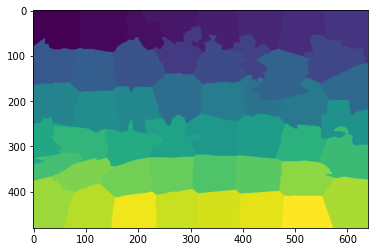

In [44]:
plt.imshow(segments_slic,aspect="auto")
plt.show()

In [45]:
# define a function that depends on a binary mask representing if an image region is hidden
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out
def f(z):
    return model.predict(preprocess_input(mask_image(z, segments_slic, images_sample, 255)))
def ab(z):
    return model.predict(images_sample)

In [49]:
# abc = mask_image(z, segments_slic, images_sample, 255)

In [34]:
# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,50)))
shap_values = explainer.shap_values(np.ones((1,50)), nsamples=1000)

  0%|          | 0/1 [00:00<?, ?it/s]

In [46]:
# get the top predictions from the model
preds = model.predict(preprocess_input(np.expand_dims(images_sample.copy(), axis=0)))
top_preds = np.argsort(-preds)

In [47]:
top_preds

array([[0]], dtype=int64)

In [26]:
# make a color map
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)

In [66]:
feature_names = {'0' : '0', '1': '1', '2': '2','3': '3','4': '4','5': '5','6': '6','7': '7','8': '8','9': '9'} 

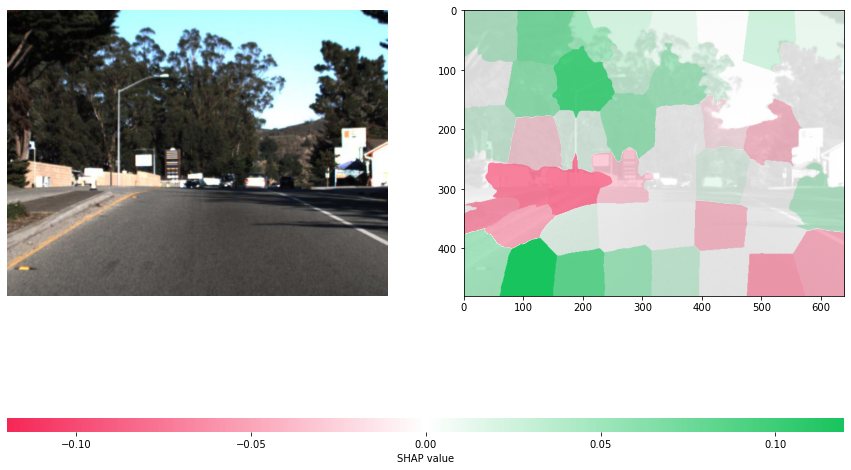

In [54]:
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

# plot our explanations
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
inds = top_preds[0]
axes[0].imshow(images_sample)
axes[0].axis('off')
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(1):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
#     axes[i+1].set_title(feature_names[str(inds[i])])
    axes[i+1].imshow(img1.convert('LA'), alpha=0.15)
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
#     axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()